In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #Import necessary packages

In [2]:
import openmeteo_requests
import requests_cache
from retry_requests import retry

# Function to calculate AQI for a given pollutant
def calculate_aqi(value, breakpoints):
    for i in range(len(breakpoints) - 1):
        if breakpoints[i] <= value <= breakpoints[i + 1]:
            return round(((AQI[i + 1] - AQI[i]) / (breakpoints[i + 1] - breakpoints[i])) * (value - breakpoints[i]) + AQI[i])
    return 0  # Default value if the pollutant value is out of range

# AQI breakpoints and corresponding AQI values for different pollutants
AQI = [0, 50, 100, 150, 200, 300, 500]
pm10_breakpoints = [0, 54, 154, 254, 354, 424, 504]
pm2_5_breakpoints = [0, 12, 35.4, 55.4, 150.4, 250.4, 350.4]
co_breakpoints = [0, 4.4, 9.4, 12.4, 15.4, 30.4, 40.4]
no2_breakpoints = [0, 53, 100, 360, 649, 1249, 2049]
so2_breakpoints = [0, 35, 75, 185, 304, 604, 1004]
ozone_breakpoints = [0, 54, 70, 85, 105, 200, 504]

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://air-quality-api.open-meteo.com/v1/air-quality"
params = {
    "latitude": 10.7905,
    "longitude": 78.7047,
    "current": ["pm10", "pm2_5", "carbon_monoxide", "nitrogen_dioxide", "sulphur_dioxide", "ozone"],
    "hourly": ["pm10", "pm2_5", "carbon_monoxide", "nitrogen_dioxide", "sulphur_dioxide", "ozone"],
    "timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

from geopy.geocoders import Nominatim

# Function to get city name based on latitude and longitude
def get_city_name(latitude, longitude):
    geolocator = Nominatim(user_agent="your_app_name")
    location = geolocator.reverse((latitude, longitude), language='en')
    
    # Extract city from the address
    address_components = location.raw.get('address', {})
    city = address_components.get('city', '')
    
    if not city:
        # If city is not available, try town or village
        city = address_components.get('town', '')
        if not city:
            city = address_components.get('village', '')
    
    return city

# Example usage
latitude = 10.7905
longitude = 78.7047

# Get city based on latitude and longitude
city = get_city_name(latitude, longitude)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_pm10 = hourly.Variables(0).ValuesAsNumpy()
hourly_pm2_5 = hourly.Variables(1).ValuesAsNumpy()
hourly_co = hourly.Variables(2).ValuesAsNumpy()
hourly_no2 = hourly.Variables(3).ValuesAsNumpy()
hourly_so2 = hourly.Variables(4).ValuesAsNumpy()
hourly_ozone = hourly.Variables(5).ValuesAsNumpy()

# Calculate AQI for each pollutant
hourly_aqi_pm10 = [calculate_aqi(value, pm10_breakpoints) for value in hourly_pm10]
hourly_aqi_pm2_5 = [calculate_aqi(value, pm2_5_breakpoints) for value in hourly_pm2_5]
hourly_aqi_co = [calculate_aqi(value, co_breakpoints) for value in hourly_co]
hourly_aqi_no2 = [calculate_aqi(value, no2_breakpoints) for value in hourly_no2]
hourly_aqi_so2 = [calculate_aqi(value, so2_breakpoints) for value in hourly_so2]
hourly_aqi_ozone = [calculate_aqi(value, ozone_breakpoints) for value in hourly_ozone]

# Create a new DataFrame with AQI values
hourly_aqi_data = {"date": pd.date_range(
    start=pd.to_datetime(hourly.Time(), unit="s"),
    end=pd.to_datetime(hourly.TimeEnd(), unit="s"),
    freq=pd.Timedelta(seconds=hourly.Interval()),
    inclusive="left"
)}
hourly_aqi_data["pm10_aqi"] = hourly_aqi_pm10
hourly_aqi_data["pm2_5_aqi"] = hourly_aqi_pm2_5
hourly_aqi_data["co_aqi"] = hourly_aqi_co
hourly_aqi_data["no2_aqi"] = hourly_aqi_no2
hourly_aqi_data["so2_aqi"] = hourly_aqi_so2
hourly_aqi_data["ozone_aqi"] = hourly_aqi_ozone
df = pd.DataFrame(data=hourly_aqi_data)
print(df)


                   date  pm10_aqi  pm2_5_aqi  co_aqi  no2_aqi  so2_aqi  \
0   2024-05-12 18:30:00        11         34       0       12        5   
1   2024-05-12 19:30:00        11         34       0       12        5   
2   2024-05-12 20:30:00        12         37       0       13        5   
3   2024-05-12 21:30:00        13         42       0       15        6   
4   2024-05-12 22:30:00        14         44       0       17        7   
..                  ...       ...        ...     ...      ...      ...   
115 2024-05-17 13:30:00        36         82       0        9        5   
116 2024-05-17 14:30:00        33         78       0       10        6   
117 2024-05-17 15:30:00        34         79       0       11        7   
118 2024-05-17 16:30:00        36         82       0       13        8   
119 2024-05-17 17:30:00        37         84       0       14        9   

     ozone_aqi  
0           36  
1           33  
2           30  
3           25  
4           19  
..       

In [3]:
df.head()

,date,pm10_aqi,pm2_5_aqi,co_aqi,no2_aqi,so2_aqi,ozone_aqi
0,2024-05-12 18:30:00,11,34,0,12,5,36
1,2024-05-12 19:30:00,11,34,0,12,5,33
2,2024-05-12 20:30:00,12,37,0,13,5,30
3,2024-05-12 21:30:00,13,42,0,15,6,25
4,2024-05-12 22:30:00,14,44,0,17,7,19


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       120 non-null    datetime64[ns]
 1   pm10_aqi   120 non-null    int64         
 2   pm2_5_aqi  120 non-null    int64         
 3   co_aqi     120 non-null    int64         
 4   no2_aqi    120 non-null    int64         
 5   so2_aqi    120 non-null    int64         
 6   ozone_aqi  120 non-null    int64         
dtypes: datetime64[ns](1), int64(6)
memory usage: 6.7 KB


In [5]:
df.describe()

,date,pm10_aqi,pm2_5_aqi,co_aqi,no2_aqi,so2_aqi,ozone_aqi
count,120,120.000000,120.000000,120.0,120.000000,120.000000,120.000000
mean,2024-05-15 06:00:00,29.450000,68.133333,0.0,8.608333,8.591667,133.908333
min,2024-05-12 18:30:00,11.000000,33.000000,0.0,1.000000,3.000000,19.000000
25%,2024-05-14 00:15:00,22.000000,59.000000,0.0,3.000000,7.000000,43.750000
50%,2024-05-15 06:00:00,28.500000,69.000000,0.0,9.000000,8.000000,138.500000
75%,2024-05-16 11:45:00,39.000000,82.000000,0.0,12.250000,10.000000,209.500000
max,2024-05-17 17:30:00,51.000000,100.000000,0.0,28.000000,17.000000,260.000000
std,NaN,10.430925,16.344985,0.0,5.851518,3.077421,81.047345


In [6]:
total = df.isna().sum()
total

date         0
pm10_aqi     0
pm2_5_aqi    0
co_aqi       0
no2_aqi      0
so2_aqi      0
ozone_aqi    0
dtype: int64

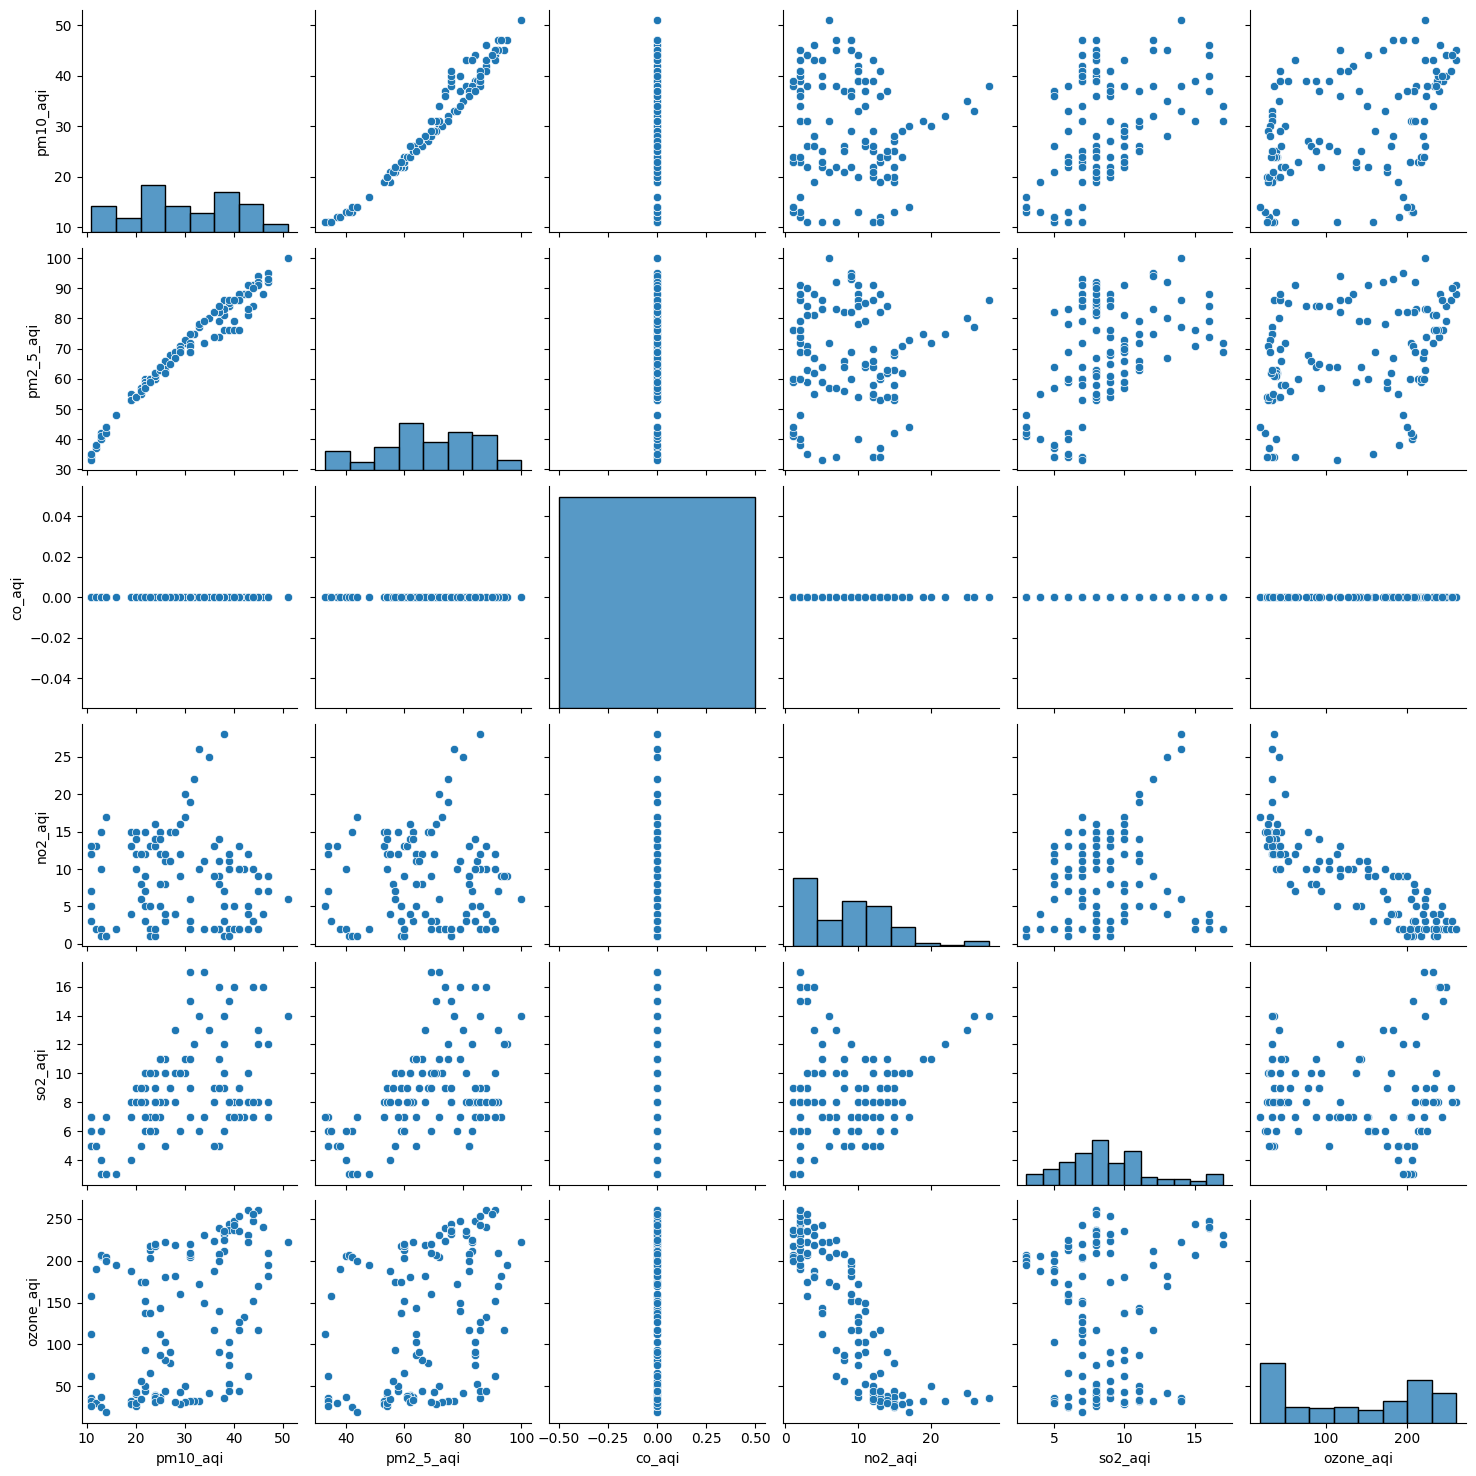

In [7]:
sns.pairplot(df)

In [8]:
pmean=df["pm2_5_aqi"].mean()
df["pm2_5_aqi"].fillna(pmean,inplace=True)

In [9]:
pmmean=df["pm10_aqi"].mean()
df["pm10_aqi"].fillna(pmmean,inplace=True)

In [10]:
cmean=df["co_aqi"].mean()
df["co_aqi"].fillna(cmean,inplace=True)

In [11]:
nomean=df["no2_aqi"].mean()
df["no2_aqi"].fillna(nomean,inplace=True)

In [12]:
smean=df["so2_aqi"].mean()
df["so2_aqi"].fillna(smean,inplace=True)

In [13]:
omean=df["ozone_aqi"].mean()
df["ozone_aqi"].fillna(omean, inplace=True)

In [14]:
df.isna().sum()

date         0
pm10_aqi     0
pm2_5_aqi    0
co_aqi       0
no2_aqi      0
so2_aqi      0
ozone_aqi    0
dtype: int64

In [15]:
x=df.iloc[:,2:13].values
y=df.iloc[:,-1].values

In [16]:
x

array([[ 68,   0,  17,   9,  20],
       [ 72,   0,  20,  10,  18],
       [ 74,   0,  23,  11,  15],
       [ 74,   0,  25,  12,  11],
       [ 74,   0,  26,  13,   8],
       [ 71,   0,  22,  16,  10],
       [ 75,   0,  17,  16,  19],
       [ 71,   0,  11,  17,  34],
       [ 60,   0,   6,  16,  48],
       [ 57,   0,   3,  14,  94],
       [ 57,   0,   2,  10, 147],
       [ 56,   0,   2,   7, 180],
       [ 56,   0,   1,   5, 201],
       [ 56,   0,   1,   5, 207],
       [ 55,   0,   1,   4, 211],
       [ 54,   0,   1,   4, 212],
       [ 54,   0,   2,   4, 211],
       [ 54,   0,   3,   4, 203],
       [ 57,   0,   7,   5, 168],
       [ 60,   0,  11,   6, 100],
       [ 59,   0,  14,   7,  48],
       [ 58,   0,  15,   7,  38],
       [ 57,   0,  14,   7,  31],
       [ 57,   0,  13,   6,  26],
       [ 56,   0,  13,   6,  23],
       [ 56,   0,  13,   6,  22],
       [ 57,   0,  13,   6,  20],
       [ 58,   0,  15,   6,  16],
       [ 60,   0,  18,   7,  12],
       [ 62,  

In [17]:
y

array([ 20,  18,  15,  11,   8,  10,  19,  34,  48,  94, 147, 180, 201,
       207, 211, 212, 211, 203, 168, 100,  48,  38,  31,  26,  23,  22,
        20,  16,  12,  12,  20,  33,  47,  94, 155, 190, 203, 206, 207,
       208, 207, 201, 168, 110,  59,  43,  35,  30,  27,  27,  26,  23,
        19,  21,  31,  44,  84, 150, 202, 219, 227, 229, 229, 228, 225,
       218, 202, 158, 110,  91,  84,  81,  78,  75,  69,  53,  46,  45,
        56,  97, 143, 190, 217, 231, 233, 228, 223, 221, 218, 212, 198,
       158, 120, 103, 100,  97,  91,  84,  78,  66,  50,  50,  78, 120,
       165, 202, 219, 232, 235, 233, 229, 229, 229, 224, 211, 182, 147,
       120, 100,  88], dtype=int64)

In [18]:
from sklearn.model_selection import train_test_split #Split arrays or matrices into random train and test subsets.

In [19]:
xtrain,xtest,ytrain,ytest= train_test_split(x,y,test_size=0.3,random_state=42)

In [20]:
from sklearn.ensemble import RandomForestRegressor #importing Random Forest Regressor
forest = RandomForestRegressor() #creating object
forest.fit(xtrain, ytrain)
#estimator = estimator.fit(data, targets)
#The fit() method helps in fitting the training dataset into an estimator (ML algorithms)

RandomForestRegressor()

In [21]:
ypred=forest.predict(xtest)
#prediction = predictor.predict(data)
#The predict() method enables us to predict the labels of the data values on the basis of the trained model.

In [22]:
x=df.iloc[:,2:13]
y=df.iloc[:,-1]

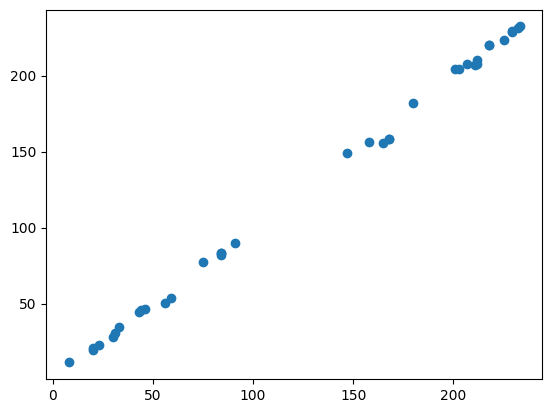

In [23]:
plt.scatter(ytest,ypred)
#The scatter() function plots one dot for each observation
#It needs two arrays of the same length, one for the values of the x-axis, and one for values on the y-axis

C:\Users\Harish\AppData\Local\Temp\ipykernel_7676\718667008.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((ytest-ypred),bins=50)


<Axes: ylabel='Density'>

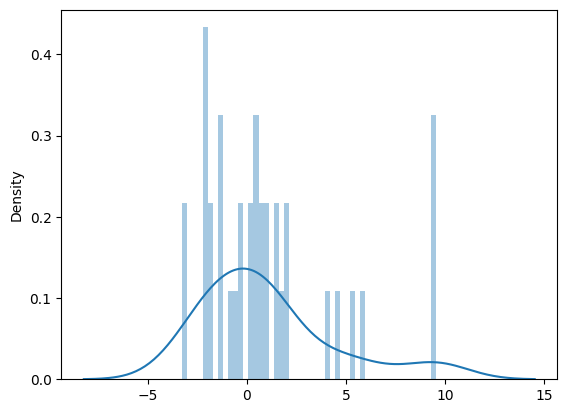

In [24]:
sns.distplot((ytest-ypred),bins=50)

In [25]:
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse,r2_score

In [26]:
print(f"MAE: {mae(ytest,ypred)}")

MAE: 2.418333333333335


In [27]:
print(f"MSE: {mse(ytest,ypred)}")

MSE: 12.29812777777778


In [28]:
print(f"RMSE: {np.sqrt(mse(ytest,ypred))}")

RMSE: 3.506868657046879


In [29]:
print(f"R-squared: {r2_score(ytest,ypred)}")

R-squared: 0.998093861476083


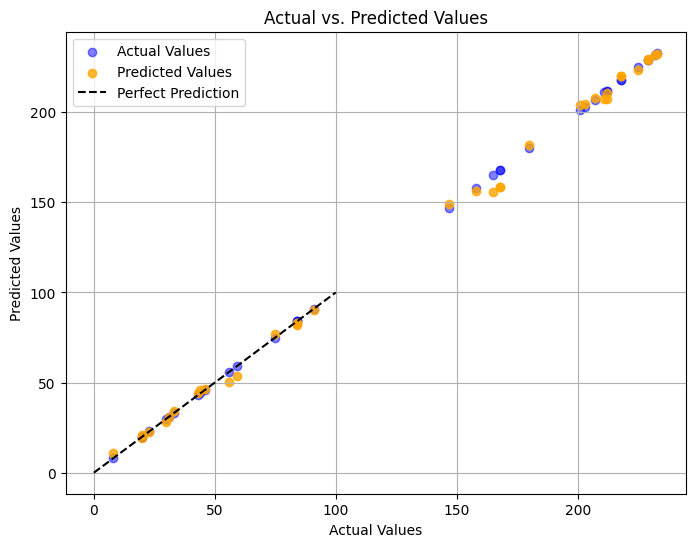

In [30]:
plt.figure(figsize=(8, 6))  # Adjust figure size as needed

# Plot the actual values (blue dots)
plt.scatter(ytest, ytest, alpha=0.5, label='Actual Values', color='blue')

# Plot the predicted values (orange dots)
plt.scatter(ytest, ypred, alpha=0.8, label='Predicted Values', color='orange')

# Add a diagonal line (y = x) for reference
plt.plot([0, 100], [0, 100], color='black', linestyle='--', label='Perfect Prediction')  # Adjust limits as needed

from IPython.display import HTML
# Customize the plot
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.savefig("my_plot.png")

In [31]:
aqi = max(pmean,pmmean,cmean,nomean,smean,omean)
formatted_aqi = round(aqi, 2)
print(formatted_aqi)

def predictDisease():
    if(aqi < 50):
        return "The air quality index is good and safe"
    if(aqi>50 and aqi < 100):
        return "The air quality index is moderate.The health issues are eye irritation,coughing or throat scratchiness."
    if(aqi>100 and aqi < 150):
        return "The air quality index is unhealthy for sensitive groups.The health issues are wheezing, difficulty breathing, and chest tightness."
    if(aqi>150 and aqi< 200):
        return "The air quality index is unhealthy for everyone.The health issues are headaches, nausea, and dizziness."
    if(aqi>200 and aqi <300):
        return "The air quality index is unhealthy for everyone and cause serious effects.The health issues are serious respiratory problems, heart attacks, and strokes."
    else:
        if(aqi> 300):
            return "The air quality index has serious health warnings of emergency conditions.The health issues are widespread health problems, even in healthy individuals. Avoid outdoor exposure."

predictDisease()

121.74


'The air quality index is unhealthy for sensitive groups.The health issues are wheezing, difficulty breathing, and chest tightness.'

In [32]:
import subprocess
from IPython.display import HTML
import http.server
import socketserver
import threading
import os

# Generate some sample data
aqi_value = formatted_aqi  # Replace this with your actual AQI data
data = f"The current Air Quality Index (AQI) is {aqi_value}"
image_source = 'my_plot.png'
output_file_path = 'output.html'
disease = predictDisease()
citydata = city
city_display = f"The choosen city is {citydata}"
# Read the HTML template file
with open('index.html', 'r') as file:
    template_content = file.read()

# Replace placeholders with the actual data
template_content = template_content.replace('CITY_PLACEHOLDER', city_display)
template_content = template_content.replace('DATA_PLACEHOLDER', data)


if(aqi_value < 50):
    template_content = template_content.replace('IMG_PLACEHOLDER','<img src="images01/Fresh Air.jpg" alt="image">')
if(aqi_value > 50 and aqi_value < 100):
    template_content = template_content.replace('IMG_PLACEHOLDER','<img src="images01/moderate.jpg" alt="image">')
if(aqi_value > 100 and aqi_value < 150):
    template_content = template_content.replace('IMG_PLACEHOLDER','<img src="images01/sensitive.jpg" alt="image">')
if(aqi_value > 150 and aqi_value < 200):
    template_content = template_content.replace('IMG_PLACEHOLDER','<img src="images01/unhealthy.jpg" alt="image">')
if(aqi_value > 200 and aqi_value < 300):
    template_content = template_content.replace('IMG_PLACEHOLDER','<img src="images01/attack.jpg" alt="image">')
if(aqi_value > 300):
    template_content = template_content.replace('IMG_PLACEHOLDER','<img src="images01/harmful.jpg" alt="image">')


template_content = template_content.replace('DISEASE_PLACEHOLDER',disease)

# Save the modified HTML content to a new file
with open(output_file_path, 'w') as output_file:
    output_file.write(template_content)

# Specify the path to the Chrome executable
chrome_path = "C:/Program Files/Google/Chrome/Application/chrome.exe"  # Adjust this path based on your system

# Create a temporary directory to serve the HTML file
temp_dir = 'temp'
os.makedirs(temp_dir, exist_ok=True)
temp_html_path = os.path.join(temp_dir, 'output.html')

with open(temp_html_path, 'w') as temp_html_file:
    temp_html_file.write(template_content)

# Attempt to use a different port
port = 8040

# Start a simple HTTP server in a separate thread
class MyHttpRequestHandler(http.server.SimpleHTTPRequestHandler):
    def log_message(self, format, *args):
        pass  # Suppress log messages

try:
    httpd = socketserver.TCPServer(('localhost', port), MyHttpRequestHandler)
except OSError as e:
    print(f"Port {port} is already in use. Trying a different port.")
    port += 1
    httpd = socketserver.TCPServer(('localhost', port), MyHttpRequestHandler)

def serve_content():
    httpd.serve_forever()

thread = threading.Thread(target=serve_content)
thread.start()

# Open the HTML file in a new Chrome window using subprocess
subprocess.Popen([chrome_path, f'http://localhost:{port}/output.html'], shell=True)

# Display the HTML content in the notebook
HTML(template_content)
